In [1]:
import os
import os.path as osp
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imsave, imread
from skimage import img_as_ubyte, img_as_float
import sys
import monai

%load_ext autoreload
%autoreload 2

In [2]:
def imshow_pair(im, gdt, vmin1=None, vmax1=None, vmin2=None, vmax2=None):
    f, ax = plt.subplots(1, 2, figsize=(10,5))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        if vmin1==None:
            ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
        else:
            ax[0].imshow(np_im, cmap='gray', vmin=vmin1, vmax=vmax1),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        if vmin2==None:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray', vmin=vmin2, vmax=vmax2), ax[1].axis('off')
        else:
            ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

In [3]:
train_img_names = list(pd.read_csv('data/DRIVE/train_av.csv').im_paths)
train_seg_names = list(pd.read_csv('data/DRIVE/train_av.csv').gt_paths)

val_img_names = list(pd.read_csv('data/DRIVE/val_av.csv').im_paths)
val_seg_names = list(pd.read_csv('data/DRIVE/val_av.csv').gt_paths)

In [4]:
fn_keys = ('img', 'seg')  # filename keys for image and seg files
train_filenames = [{'img': x, 'seg': y} for x,y in zip(train_img_names, train_seg_names)]

val_filenames = [{'img': x, 'seg': y} for x,y in zip(val_img_names, val_seg_names)]

In [5]:
from monai.transforms import MapTransform

# for type hinting at this stage we need more
from monai.config import KeysCollection
from typing import Optional, Any, Mapping, Hashable

## Loading Datasets

With a data source and transforms defined we can now create a dataset object. The base class for MONAI is `Dataset`, created here to load the image files only:

In [6]:
from monai.data import Dataset, ArrayDataset

In [7]:
from monai.transforms import Compose, LoadImageD, ToTensorD, AddChannelD, AsChannelFirstD, RandSpatialCropD, \
                            ScaleIntensityD, RandAdjustContrastD, RandRotateD, RandAffineD, \
                            Rand2DElasticD, RandFlipD, RandZoomD, CropForegroundd, ResizeWithPadOrCropD

In [8]:
train_transforms = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8 ),
        AsChannelFirstD(keys=('img',)),
        AddChannelD(keys=('seg',)),
        CropForegroundd(keys=('img','seg'), source_key='seg'),
        ScaleIntensityD(keys=('img',)),
        RandAdjustContrastD(keys=('img',), prob=0.25, gamma=(0.5, 2.5)),
        RandAffineD(keys=('img','seg'), rotate_range=np.pi/4, 
                                   shear_range = (0.025 ,0.025), 
                                   translate_range = (0.0 ,0.0), # since we random-crop
                                   scale_range= (0.0 ,0.0),
                                   padding_mode='zeros', mode=('bilinear','nearest'), 
                                   prob=0.5), 
        RandFlipD(keys=('img','seg'), prob=0.5, spatial_axis=(0,)), # vertical flip
        RandFlipD(keys=('img','seg'), prob=0.5, spatial_axis=(1,)), # horizontal flip
        RandZoomD(keys=('img','seg'), prob=0.5, min_zoom=0.95), # random zoom of 95%-110%
        RandSpatialCropD(keys=('img','seg'), roi_size=(256,256), random_size=False),
        ToTensorD(keys=('img', 'seg')),
    ]
)

train_ds = Dataset(train_filenames, train_transforms)

In [9]:
val_transforms = Compose(
    [
        LoadImageD(keys=('img', 'seg'), dtype=np.uint8 ),
        AsChannelFirstD(keys=('img',)),
        AddChannelD(keys=('seg',)),
        CropForegroundd(keys=('img','seg'), source_key='seg'),
        ScaleIntensityD(keys=('img',)),
        ResizeWithPadOrCropD(keys=('img','seg'), spatial_size=(512,512)),
        ToTensorD(keys=('img', 'seg')),
    ]
)

val_ds = Dataset(val_filenames, val_transforms)

torch.Size([1, 256, 256])

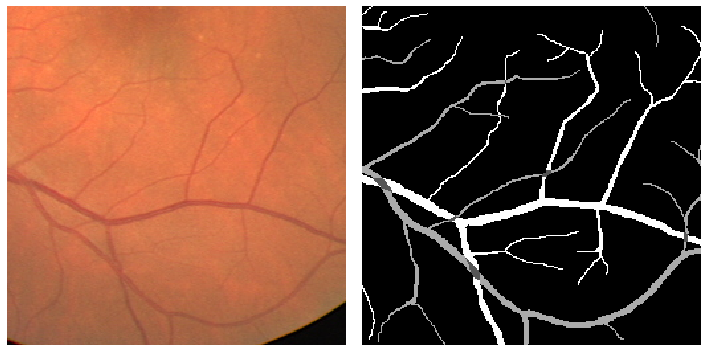

In [95]:
inputs = train_ds[0]
im, tg = inputs['img'], inputs['seg']
imshow_pair(im.numpy().transpose(1,2,0), tg[0])
tg.shape

torch.Size([1, 512, 512])

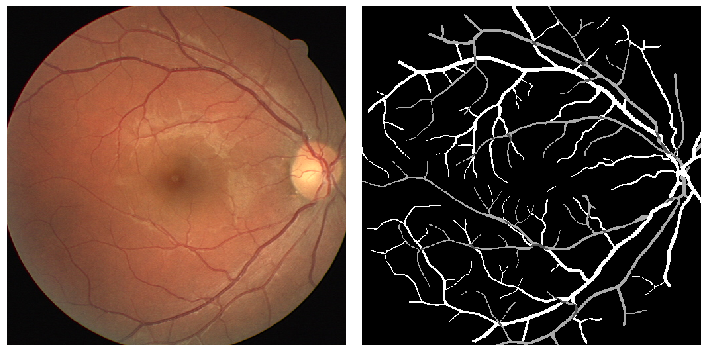

In [96]:
inputs = val_ds[0]
im, tg = inputs['img'], inputs['seg']
imshow_pair(im.numpy().transpose(1,2,0), tg[0])
tg.shape

In [11]:
from monai.data import CacheDataset, Dataset, PersistentDataset
import torch

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
device

device(type='cpu', index=0)

In [13]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
# print(root_dir)

In [235]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4,)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=4)

In [217]:
x = next(iter(train_loader))
x['seg'].shape

torch.Size([2, 1, 256, 256])

In [218]:
x = next(iter(val_loader))
x['seg'].shape

torch.Size([2, 1, 512, 512])

In [15]:
n_classes=4

In [16]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

model = UNet(
        dimensions=2,
        in_channels=3,
        out_channels=n_classes,
        channels=(8, 16, 32),
        strides=(2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

In [17]:
x = next(iter(train_loader))
model(x['img']).shape

torch.Size([2, 4, 256, 256])

In [18]:
x = next(iter(val_loader))
model(x['img'].float()).shape

torch.Size([1, 4, 512, 512])

In [19]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

25169

In [20]:
optimizer = torch.optim.Adam(model.parameters(), 1e-2)
criterion = torch.nn.CrossEntropyLoss()

In [28]:
cycle_lens = [20, 50]
grad_acc_steps=0
n_cycles = cycle_lens[0]
min_lr = 1e-8

In [41]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                              T_max=cycle_lens[0] * len(train_loader) // (grad_acc_steps + 1), 
                              eta_min=min_lr)
setattr(scheduler, 'cycle_lens', cycle_lens)

In [30]:
from tqdm import trange

In [31]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [243]:
def run_one_epoch(loader, model, criterion, optimizer=None, scheduler=None, grad_acc_steps=0, assess=False):
    device='cuda' if next(model.parameters()).is_cuda else 'cpu'
    train = optimizer is not None  # if we are in training mode there will be an optimizer and train=True here

    if train: model.train()
    else: model.eval()
    if assess: logits_all, labels_all = [], []
    n_elems, running_loss, running_loss_ce, running_loss_sim = 0, 0, 0, 0
    for i_batch, batch_data in enumerate(loader):
        inputs, labels = (batch_data["img"].to(device), batch_data["seg"].to(device), )
        if train:  # only in training mode
            logits = model(inputs)
            loss = criterion(logits.squeeze(), (labels.squeeze()/(255/(n_classes-1))).long())
            (loss / (grad_acc_steps + 1)).backward()
            if i_batch % (grad_acc_steps+1) == 0:  # for grad_acc_steps=0, this is always True
                optimizer.step()
                for _ in range(grad_acc_steps+1): scheduler.step() # for grad_acc_steps=0, this means once
                optimizer.zero_grad()
        
        else:
            logits = sliding_window_inference(inputs[0].unsqueeze(0).float(), 
                                       roi_size=(256,256), sw_batch_size=1, 
                                       predictor=model, overlap=0.5, mode='gaussian')
            loss = criterion(logits, (labels.squeeze(dim=1)/(255/(n_classes-1))).long())

        if assess:
            logits_all.extend(logits.detach().cpu())
            labels_all.extend(labels.cpu())

        # Compute running loss
        running_loss += loss.item() * inputs.size(0)
        n_elems += inputs.size(0)
        run_loss = running_loss / n_elems
            
    if assess: return logits_all, labels_all, run_loss
    else: return None, None, run_loss

In [89]:
def train_one_cycle(train_loader, model, criterion, optimizer=None, scheduler=None, grad_acc_steps=0, cycle=0):
    # prepare next cycle:
    # reset iteration counter
    scheduler.last_epoch = -1
    # update number of iterations
    scheduler.T_max = scheduler.cycle_lens[cycle] * len(train_loader)
    
    model.train()
    optimizer.zero_grad()
    cycle_len = scheduler.cycle_lens[cycle]
    with trange(cycle_len) as t:
        for epoch in range(cycle_len):
#             print('Cycle {:d} | Epoch {:d}/{:d}'.format(cycle+1, epoch+1, cycle_len))
            if epoch == cycle_len-1: assess=True # only get logits/labels on last cycle
            else: assess = False
            tr_logits, tr_labels, tr_loss = run_one_epoch(train_loader, model, criterion, optimizer=optimizer,
                                                          scheduler=scheduler, grad_acc_steps=grad_acc_steps, 
                                                          assess=assess)
            t.set_postfix_str("tr loss={:.4f} / LR={:.6f}".format(float(tr_loss), get_lr(optimizer)))
            t.update()
    return tr_logits, tr_labels, tr_loss

In [90]:
# logits, labels, loss = run_one_epoch(train_loader, model, criterion, optimizer, 
#                                      scheduler, grad_acc_steps, assess=False)

In [188]:
for cycle in range(10):
    logits, labels, loss = train_one_cycle(train_loader,model, criterion, optimizer,scheduler, cycle=0)

100%|██████████| 20/20 [00:51<00:00,  2.59s/it, tr loss=0.1163 / LR=0.000001]


In [236]:
with torch.no_grad():
    vl_logits, vl_labels, vl_loss = run_one_epoch(val_loader, model, criterion, optimizer=None, assess=True)

torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])


In [238]:
val_data = val_loader.dataset.data.copy()
val_loader.dataset.data = train_loader.dataset.data

In [240]:
val_loader.dataset.data = val_data

In [242]:
with torch.no_grad():
    vl_logits, vl_labels, vl_loss = run_one_epoch(val_loader, model, criterion, optimizer=None, assess=True)

torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 4, 512, 512])


In [244]:
val_data = val_loader.dataset.data.copy()
val_loader.dataset.data = train_loader.dataset.data
with torch.no_grad():
    tr_logits, tr_labels, tr_loss = run_one_epoch(val_loader, model, criterion, optimizer=None, assess=True)
val_loader.dataset.data = val_data

In [251]:
np.unique(pred)

array([  0.,  85., 170., 255.], dtype=float32)

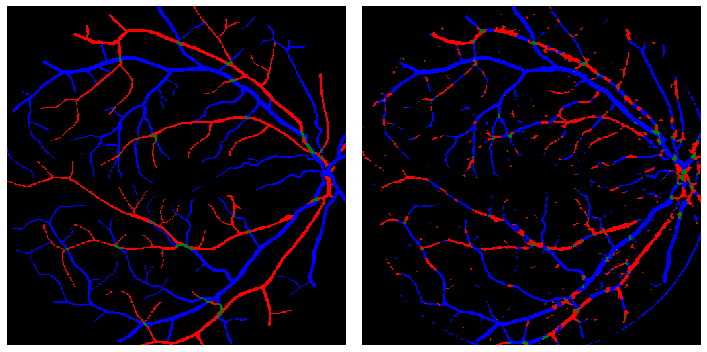

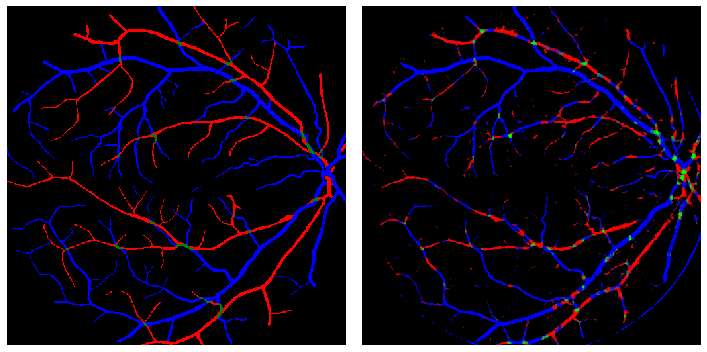

In [252]:
from skimage.color import label2rgb
pred = torch.argmax(vl_logits[0],dim=0)*(255/(n_classes-1))
pred_rgb = label2rgb(pred.numpy().astype(int), colors=['black', 'green', 'red', 'blue'])
gt = vl_labels[0][0]
gt_rgb = label2rgb(gt.numpy(), colors=['black', 'green', 'red', 'blue'])

probs = torch.nn.Softmax(dim=0)(vl_logits[0])
back = (pred==0).float()
xx = np.stack([probs[2]*(1-back),probs[1]*(1-back),probs[3]*(1-back)], axis=2)

imshow_pair(gt_rgb, pred_rgb)
imshow_pair(gt_rgb, xx)

In [249]:
vl_logits[0].shape, tr_logits[0].shape

(torch.Size([4, 512, 512]), torch.Size([4, 512, 512]))

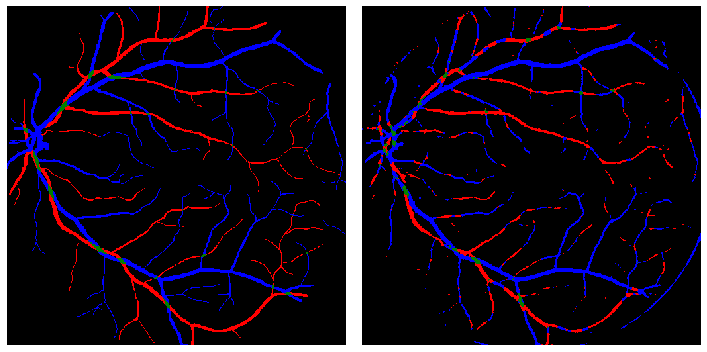

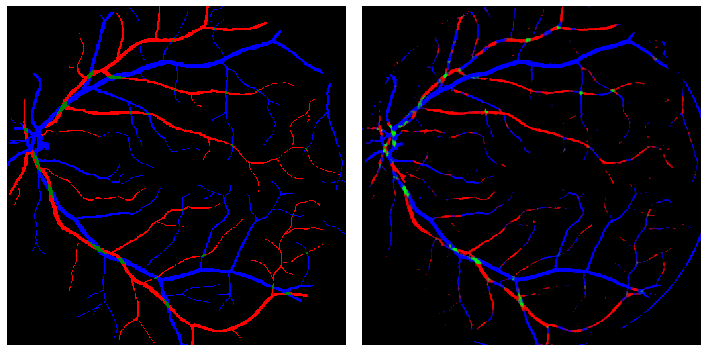

In [253]:
from skimage.color import label2rgb
pred = torch.argmax(tr_logits[0],dim=0)*(255/(n_classes-1))
pred_rgb = label2rgb(pred.numpy().astype(int), colors=['black', 'green', 'red', 'blue'])
gt = tr_labels[0][0]
gt_rgb = label2rgb(gt.numpy(), colors=['black', 'green', 'red', 'blue'])

probs = torch.nn.Softmax(dim=0)(tr_logits[0])
back = (pred==0).float()
xx = np.stack([probs[2]*(1-back),probs[1]*(1-back),probs[3]*(1-back)], axis=2)

imshow_pair(gt_rgb, pred_rgb)
imshow_pair(gt_rgb, xx)